In [1]:
!ln -s /data /habitat-api/data

ln: failed to create symbolic link '/habitat-api/data/data': File exists


In [2]:
import habitat
import numpy as np
from tqdm.notebook import tqdm, trange
import torch
import matplotlib.pyplot as plt
import random
import torch.nn as nn
# from tensorboardX import SummaryWriter
from Vec_env import create_envs
from Utils import AverageMeter, DepthNorm
from Data import getTrainTestData
from Loss import ssim
import os

In [3]:
%cd ../../../habitat-api/
%ls

/habitat-api
CODE_OF_CONDUCT.md  README.md  habitat/            res/
CONTRIBUTING.md     configs/   habitat.egg-info/   setup.cfg
Dockerfile          data@      habitat_baselines/  setup.py
LICENSE             docs/      pyproject.toml      test/
MANIFEST.in         examples/  requirements.txt    wandb/


#### Create vector of envs for parallel online training

In [4]:
H = 360
W = 640
#----- Previous pointnav config
# config = habitat.get_config(config_paths='configs/tasks/pointnav_gibson.yaml')
# config.defrost()
# config.SIMULATOR.AGENT_0.SENSORS = ['RGB_SENSOR',  'DEPTH_SENSOR']
# config.SIMULATOR.RGB_SENSOR.HEIGHT = H
# config.SIMULATOR.RGB_SENSOR.WIDTH = W
# config.SIMULATOR.DEPTH_SENSOR.HEIGHT = H
# config.SIMULATOR.DEPTH_SENSOR.WIDTH = W
# config.TASK.SENSORS = ["HEADING_SENSOR", "COMPASS_SENSOR", "GPS_SENSOR", "POINTGOAL_SENSOR", "POINTGOAL_WITH_GPS_COMPASS_SENSOR"]
# config.TASK.POINTGOAL_WITH_GPS_COMPASS_SENSOR.DIMENSIONALITY = 3
# config.TASK.POINTGOAL_WITH_GPS_COMPASS_SENSOR.GOAL_FORMAT = "CARTESIAN"
# config.TASK.POINTGOAL_SENSOR.DIMENSIONALITY = 3
# config.TASK.POINTGOAL_SENSOR.GOAL_FORMAT = "CARTESIAN"
# config.TASK.GPS_SENSOR.DIMENSIONALITY = 3
# config.TASK.GPS_SENSOR.GOAL_FORMAT = "CARTESIAN"
# # config.DATASET.DATA_PATH = 'data/datasets/pointnav/gibson/v1/val/val.json.gz'
# config.freeze()
# envs = create_envs(1, config)

In [5]:
config_paths="./data/habitat-challenge/habitat-challenge-data/challenge_pointnav2020.local.rgbd.yaml"
config = habitat.get_config(config_paths=config_paths)
config.defrost()
config.SIMULATOR.RGB_SENSOR.HEIGHT = H
config.SIMULATOR.RGB_SENSOR.WIDTH = W
#noise = 0
config.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS.intensity_constant = 0
# config.SIMULATOR.AGENT_0.RADIUS = 0
# config.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 0
# config.SIMULATOR.RGB_SENSOR.POSITION = [0, 0, 0]
# config.SIMULATOR.DEPTH_SENSOR.POSITION = [0, 0, 0]
config.SIMULATOR.DEPTH_SENSOR.HEIGHT = H
config.SIMULATOR.DEPTH_SENSOR.WIDTH = W
# config.SIMULATOR.DEPTH_SENSOR.NOISE_MODEL = False
config.DATASET.DATA_PATH = './data/datasets/pointnav/gibson/v1/{split}/{split}.json.gz'
# config.DATASET.SPLIT = 'train'
# config.DATASET.SPLIT = 'val'
config.DATASET.SPLIT = 'val_mini'
config.DATASET.SCENES_DIR = '/data/scene_datasets/'
config.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
config.TASK.SENSORS = ["HEADING_SENSOR", "COMPASS_SENSOR", "GPS_SENSOR", "POINTGOAL_SENSOR", "POINTGOAL_WITH_GPS_COMPASS_SENSOR"]
config.TASK.POINTGOAL_WITH_GPS_COMPASS_SENSOR.DIMENSIONALITY = 3
config.TASK.POINTGOAL_WITH_GPS_COMPASS_SENSOR.GOAL_FORMAT = "CARTESIAN"
config.TASK.POINTGOAL_SENSOR.DIMENSIONALITY = 3
config.TASK.POINTGOAL_SENSOR.GOAL_FORMAT = "CARTESIAN"
config.TASK.GPS_SENSOR.DIMENSIONALITY = 3
config.TASK.GPS_SENSOR.GOAL_FORMAT = "CARTESIAN"
config.freeze()
envs = create_envs(1, config)

2020-04-26 17:42:54,187 Initializing dataset PointNav-v1
2020-04-26 17:42:54,199 initializing sim Sim-v0
2020-04-26 17:42:58,679 Initializing task Nav-v0


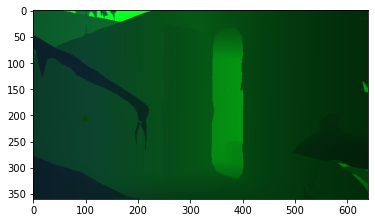

In [6]:
plt.imshow(np.concatenate((envs.reset()[0]['depth'], envs.reset()[0]['depth'], envs.reset()[0]['depth']), axis=2))

In [7]:
print("Action 2")
envs.reset()
for i in range(20):
    obs = envs.step([2])[0]
    print('Compas: ', obs['compass'], 'Gps: ', obs['gps'])
print('-------')
print('Action 1')
for i in range(20):
    obs = envs.step([1])[0]
    print('Compas: ', obs['compass'], 'Gps: ', obs['gps'])

Action 2
Compas:  [0.322689] Gps:  [ 1.9618182e-02 -3.5762787e-06  1.3911825e-03]
Compas:  [0.60954714] Gps:  [-9.1354446e-03 -3.5762787e-06  1.7131833e-02]
Compas:  [0.7038162] Gps:  [-4.2904824e-02 -3.5762787e-06 -4.3498946e-04]
Compas:  [0.90958685] Gps:  [-8.2690708e-02 -3.5762787e-06  1.8896243e-02]
Compas:  [1.1645855] Gps:  [-9.4778195e-02 -3.5762787e-06 -1.1523453e-03]
Compas:  [1.4239575] Gps:  [-8.4245093e-02 -3.5762787e-06 -2.8409531e-02]
Compas:  [1.7049682] Gps:  [-5.8914036e-02 -3.5762787e-06 -4.9177866e-02]
Compas:  [1.9220899] Gps:  [-7.2770059e-02 -3.5762787e-06 -3.3082042e-02]
Compas:  [2.0385022] Gps:  [-9.7234510e-02 -3.5762787e-06 -1.9731458e-02]
Compas:  [2.1560247] Gps:  [-4.2617522e-02 -3.5762787e-06  5.1738080e-02]
Compas:  [2.3616872] Gps:  [-1.4901084e-02 -3.5762787e-06  8.0031067e-02]
Compas:  [2.5648146] Gps:  [ 5.1582891e-02 -3.5762787e-06  1.1783862e-01]
Compas:  [2.7420733] Gps:  [ 1.0884533e-02 -3.5762787e-06  8.5289069e-02]
Compas:  [2.928029] Gps:  [-

## Collect dataset

In [8]:
from PIL import Image
import csv

In [9]:
# (prev_depth * 256).astype(np.uint8).shape

## Train

In [10]:
obs = envs.reset()[0]
prev_rgb = None
prev_depth = None
prev_gps = None
prev_compas = None
curr_rgb = obs['rgb']
curr_depth = obs['depth']
curr_gps = obs['gps']
curr_compas = obs['compass'] + np.pi

# print(envs.step([1])[0]['gps'] - prev_gps)
with open('./data/Odom_data/Without_noise/Train/train.csv', mode='w') as file:
    test_writer = csv.writer(file, delimiter=',', quotechar='\"', quoting=csv.QUOTE_MINIMAL)
    for i in trange(5000):
        act = np.random.choice(4)
        obs = envs.step([act])[0]
        if act == 0:
            prev_rgb = None
            prev_depth = None
            prev_gps = None
            prev_compas = None
            curr_rgb = obs['rgb']
            curr_depth = obs['depth']
            curr_gps = obs['gps']
            curr_compas = obs['compass'] + np.pi
        else:
            prev_rgb, curr_rgb = curr_rgb, obs['rgb']
            prev_depth, curr_depth = curr_depth, obs['depth']
            prev_gps, curr_gps = curr_gps, obs['gps']
            prev_compas, curr_compas = curr_compas, obs['compass'] + np.pi
        if prev_rgb is not None:
            rgb0 = Image.fromarray(prev_rgb)
            rgb1 = Image.fromarray(curr_rgb)
            depth0 = Image.fromarray((prev_depth[:,:,0] * 256).astype(np.uint8))
            depth1 = Image.fromarray((curr_depth[:,:,0] * 256).astype(np.uint8))
            rgb0.save('./data/Odom_data/Without_noise/Train/{}_r0.png'.format(i))
            rgb1.save('./data/Odom_data/Without_noise/Train/{}_r1.png'.format(i))
            depth0.save('./data/Odom_data/Without_noise/Train/{}_d0.png'.format(i))
            depth1.save('./data/Odom_data/Without_noise/Train/{}_d1.png'.format(i))
            df = curr_compas - prev_compas
            if abs(df) > np.pi:
                if curr_compas > prev_compas:
                    df = curr_compas - prev_compas - 2 * np.pi
                else:
                    df = curr_compas - prev_compas + 2 * np.pi
                
            test_writer.writerow(['{}_r0.png'.format(i), 
                                  '{}_r1.png'.format(i),
                                  '{}_d0.png'.format(i),
                                  '{}_d1.png'.format(i),
                                  curr_gps - prev_gps,
                                  df,
                                  prev_compas - np.pi])

## Validation

In [11]:
config_paths="./data/habitat-challenge/habitat-challenge-data/challenge_pointnav2020.local.rgbd.yaml"
config = habitat.get_config(config_paths=config_paths)
config.defrost()
config.SIMULATOR.RGB_SENSOR.HEIGHT = H
config.SIMULATOR.RGB_SENSOR.WIDTH = W
#noise = 0
config.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS.intensity_constant = 0
# config.SIMULATOR.AGENT_0.RADIUS = 0
# config.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 0
# config.SIMULATOR.RGB_SENSOR.POSITION = [0, 0, 0]
# config.SIMULATOR.DEPTH_SENSOR.POSITION = [0, 0, 0]
config.SIMULATOR.DEPTH_SENSOR.HEIGHT = H
config.SIMULATOR.DEPTH_SENSOR.WIDTH = W
config.DATASET.DATA_PATH = './data/datasets/pointnav/gibson/v1/{split}/{split}.json.gz'
# config.DATASET.SPLIT = 'val'
config.DATASET.SPLIT = 'val_mini'
config.DATASET.SCENES_DIR = '/data/scene_datasets/'
config.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
config.TASK.SENSORS = ["HEADING_SENSOR", "COMPASS_SENSOR", "GPS_SENSOR", "POINTGOAL_SENSOR", "POINTGOAL_WITH_GPS_COMPASS_SENSOR"]
config.TASK.POINTGOAL_WITH_GPS_COMPASS_SENSOR.DIMENSIONALITY = 3
config.TASK.POINTGOAL_WITH_GPS_COMPASS_SENSOR.GOAL_FORMAT = "CARTESIAN"
config.TASK.POINTGOAL_SENSOR.DIMENSIONALITY = 3
config.TASK.POINTGOAL_SENSOR.GOAL_FORMAT = "CARTESIAN"
config.TASK.GPS_SENSOR.DIMENSIONALITY = 3
config.TASK.GPS_SENSOR.GOAL_FORMAT = "CARTESIAN"
config.freeze()
envs = create_envs(1, config)

2020-04-26 18:08:14,542 Initializing dataset PointNav-v1
2020-04-26 18:08:14,565 initializing sim Sim-v0
2020-04-26 18:08:19,892 Initializing task Nav-v0


In [12]:
obs = envs.reset()[0]
prev_rgb = None
prev_depth = None
prev_gps = None
prev_compas = None
curr_rgb = obs['rgb']
curr_depth = obs['depth']
curr_gps = obs['gps']
curr_compas = obs['compass'] + np.pi

# print(envs.step([1])[0]['gps'] - prev_gps)
with open('./data/Odom_data/Without_noise/Val/val.csv', mode='w') as file:
    test_writer = csv.writer(file, delimiter=',', quotechar='\"', quoting=csv.QUOTE_MINIMAL)
    for i in trange(500):
        act = np.random.choice(4)
        obs = envs.step([act])[0]
        if act == 0:
            prev_rgb = None
            prev_depth = None
            prev_gps = None
            prev_compas = None
            curr_rgb = obs['rgb']
            curr_depth = obs['depth']
            curr_gps = obs['gps']
            curr_compas = obs['compass'] + np.pi
        else:
            prev_rgb, curr_rgb = curr_rgb, obs['rgb']
            prev_depth, curr_depth = curr_depth, obs['depth']
            prev_gps, curr_gps = curr_gps, obs['gps']
            prev_compas, curr_compas = curr_compas, obs['compass'] + np.pi
        if prev_rgb is not None:
            rgb0 = Image.fromarray(prev_rgb)
            rgb1 = Image.fromarray(curr_rgb)
            depth0 = Image.fromarray((prev_depth[:,:,0] * 256).astype(np.uint8))
            depth1 = Image.fromarray((curr_depth[:,:,0] * 256).astype(np.uint8))
            rgb0.save('./data/Odom_data/Without_noise/Val/{}_r0.png'.format(i))
            rgb1.save('./data/Odom_data/Without_noise/Val/{}_r1.png'.format(i))
            depth0.save('./data/Odom_data/Without_noise/Val/{}_d0.png'.format(i))
            depth1.save('./data/Odom_data/Without_noise/Val/{}_d1.png'.format(i))
            df = curr_compas - prev_compas
            if abs(df) > np.pi:
                if curr_compas > prev_compas:
                    df = curr_compas - prev_compas - 2 * np.pi
                else:
                    df = curr_compas - prev_compas + 2 * np.pi
                
            test_writer.writerow(['{}_r0.png'.format(i),
                                  '{}_r1.png'.format(i),
                                  '{}_d0.png'.format(i),
                                  '{}_d1.png'.format(i),
                                  curr_gps - prev_gps,
                                  df,
                                  prev_compas - np.pi])

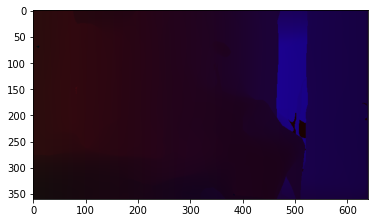

In [13]:
plt.imshow(np.concatenate((envs.reset()[0]['depth'], envs.reset()[0]['depth'], envs.reset()[0]['depth']), axis=2))

In [14]:
envs.reset()[0]['depth'].shape

(360, 640, 1)

In [15]:
envs.reset()[0]['depth'].max()

1.0

In [16]:
print("Action 2")
obs = envs.reset()
last_obs2 = obs[0]['gps']
cur_obs2 = None
last_obs = obs[0]['compass']
cur_obs = None
for i in range(20):
    obs = envs.step([2])[0]
    cur_obs = obs['compass']
    cur_obs2 = obs['gps']
    print('Compas: ',cur_obs-last_obs, 'Gps: ',cur_obs2-last_obs2)
    last_obs = cur_obs
    last_obs2 = cur_obs2
print('-------')
print('Action 1')
for i in range(20):
    obs = envs.step([1])[0]
    cur_obs = obs['compass']
    cur_obs2 = obs['gps']
    print('Compas: ',cur_obs-last_obs, 'Gps: ',cur_obs2-last_obs2)
    last_obs = cur_obs
    last_obs2 = cur_obs2

Action 2
Compas:  [0.151275] Gps:  [-2.1205205e-02 -3.5762787e-06 -2.4772740e-03]
Compas:  [0.17290165] Gps:  [ 0.00984416  0.         -0.02727184]
Compas:  [0.11353463] Gps:  [-0.03090178  0.          0.04180898]
Compas:  [0.32102057] Gps:  [0.01080503 0.         0.02388446]
Compas:  [0.21973777] Gps:  [ 0.01816383  0.         -0.04421479]
Compas:  [0.2188127] Gps:  [ 0.02122854  0.         -0.03651717]
Compas:  [0.21528721] Gps:  [-0.0157944   0.         -0.02895668]
Compas:  [0.13520801] Gps:  [-0.01066973  0.         -0.00366637]
Compas:  [0.29227686] Gps:  [-0.01868523  0.         -0.03952894]
Compas:  [0.20044887] Gps:  [-0.0213703   0.         -0.01579335]
Compas:  [0.1496284] Gps:  [ 0.03116214  0.         -0.03042978]
Compas:  [0.20213675] Gps:  [ 0.00402695  0.         -0.02218075]
Compas:  [0.22168398] Gps:  [ 0.00185268  0.         -0.00531913]
Compas:  [0.18689704] Gps:  [-0.01676418  0.         -0.02956158]
Compas:  [0.13137221] Gps:  [ 0.01272159  0.         -0.00227466]